<a href="https://colab.research.google.com/github/porekhov/drug_design_2024/blob/main/building_pharmacophore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title **Install Conda Colab, rdkit, and other dependences**
%%capture
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c conda-forge rdkit -y
!pip install py3Dmol
!pip install chembl_webresource_client

In [2]:
import collections
from collections import Counter
from pathlib import Path
import operator
import time
import math

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, cluster

from rdkit import RDConfig, Chem, Geometry, DistanceGeometry

from rdkit.Chem import (
    ChemicalFeatures,
    rdDistGeom,
    Draw,
    rdMolTransforms,
    AllChem,
    rdFMCS
)
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.Numerics import rdAlignment

import py3Dmol

In [4]:
mol_files = sorted(Path("./").glob("*_lig.pdb"))
print([f.name for f in mol_files])

# NBVAL_CHECK_OUTPUT
pdb_ids = [Path(file).stem.split("_")[0] for file in mol_files]
pdb_ids

['5hg8_lig.pdb', '5ug8_lig.pdb', '5ug9_lig.pdb', '5ugc_lig.pdb']


['5hg8', '5ug8', '5ug9', '5ugc']

In [5]:
# NBVAL_CHECK_OUTPUT
molecules = []
for mol_file in mol_files:
    molecule = Chem.MolFromPDBFile(str(mol_file), removeHs=False)
    if molecule is None:
        print(mol_file, "Could not be read")
    else:
        Chem.SanitizeMol(molecule)
        print(Chem.MolToSmiles(molecule))
        molecules.append(molecule)
print(f"Number of molecules: {len(molecules)}")

CCC(O)NC1CCCC(OC2NC(NC3CNN(C)C3)NC3NCCC32)C1
CCC(O)N[C@@H]1CN(C2NC(NC3CNN(C)C3)C3NCN(C(C)C)C3N2)C[C@H]1F
CCC(O)N[C@@H]1CN(C2NC(NC3CN(C)NC3OC)C3NCN(C(C)C)C3N2)C[C@H]1F
CCC(O)N[C@@H]1CN(C2NC(NC3CN(C)NC3OC)C3NCN(C)C3N2)C[C@H]1F
Number of molecules: 4


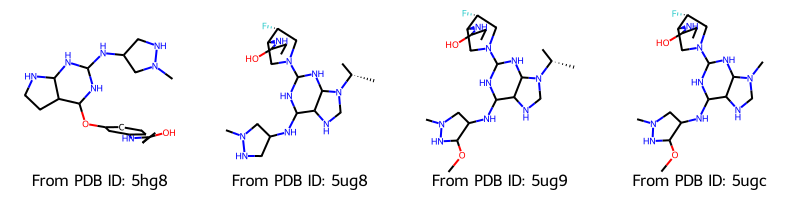

In [6]:
Draw.MolsToGridImage(
    molecules,
    molsPerRow=4,
    legends=[f"From PDB ID: {pdb_id}" for pdb_id in pdb_ids],
)

[18:37:21] WARNING: More than one matching pattern found - picking one

[18:37:21] WARNING: More than one matching pattern found - picking one



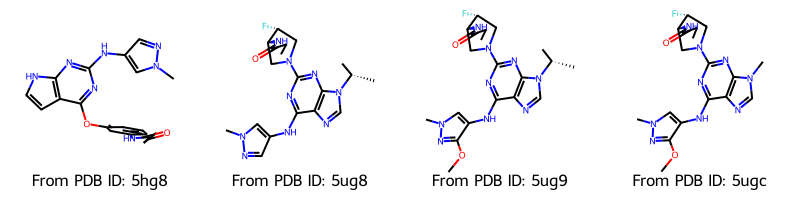

In [7]:
# SMILES in the same order as in pdb_ids
ligand_smiles = ['CCC(=O)NC1=CC(=CC=C1)OC2=NC(=NC3=C2C=CN3)NC4=CN(N=C4)C',
'CCC(=O)N[C@@H]1CN(C[C@H]1F)C2=NC(=C3C(=N2)N(C=N3)C(C)C)NC4=CN(N=C4)C',
'CCC(=O)N[C@@H]1CN(C[C@H]1F)C2=NC(=C3C(=N2)N(C=N3)C(C)C)NC4=CN(N=C4OC)C',
'CCC(=O)N[C@@H]1CN(C[C@H]1F)C2=NC(=C3C(=N2)N(C=N3)C)NC4=CN(N=C4OC)C']


# Generate RDKit Mol object from SMILES
reference_molecules = [Chem.MolFromSmiles(smiles) for smiles in ligand_smiles]

# Assign bond orders to molecules based on SMILES patterns of reference molecules
molecules = [
    AllChem.AssignBondOrdersFromTemplate(reference_molecule, molecule)
    for reference_molecule, molecule in zip(reference_molecules, molecules)
]

Draw.MolsToGridImage(
    molecules,
    molsPerRow=4,
    legends=[f"From PDB ID: {pdb_id}" for pdb_id in pdb_ids],
)

In [8]:
match =  rdFMCS.FindMCS(molecules, ringMatchesRingOnly = True)
print(match.smartsString)
# Draw substructure from Smarts
Draw.MolToImage(Chem.MolFromSmarts(match.smartsString), legend="MCS")

mcs_mol = Chem.MolFromSmarts(match.smartsString)

for mol in molecules[1:]:
    match1 = molecules[0].GetSubstructMatch(mcs_mol)
    match2 = mol.GetSubstructMatch(mcs_mol)
    AllChem.AlignMol(mol, molecules[0], atomMap=list(zip(match2, match1)))

[#7&R](:&@[#6&R]:&@[#7&R]:&@[#6&R]:&@[#6&R]):&@[#6&R]-&!@[#7&!R]-&!@[#6]1:&@[#6]:&@[#7](:&@[#7]:&@[#6]:&@1)-&!@[#6&!R]


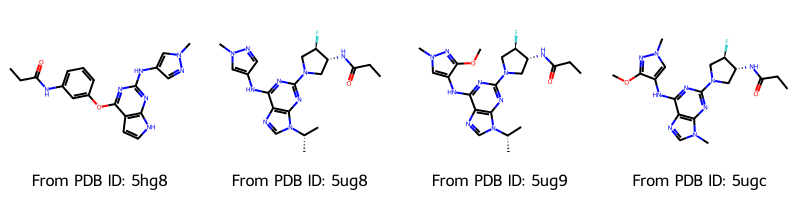

In [9]:
molecules_2d = []
for molecule in molecules:
    tmp = Chem.Mol(molecule)
    AllChem.Compute2DCoords(tmp)
    molecules_2d.append(tmp)
Draw.MolsToGridImage(
    molecules_2d,
    molsPerRow=4,
    legends=[f"From PDB ID: {pdb_id}" for pdb_id in pdb_ids],
)

In [10]:
view = py3Dmol.view(width=400, height=300)
for mol in molecules:
    mblock = Chem.MolToMolBlock(mol)
    view.addModel(mblock, 'mol')
    view.setStyle({'stick':{'radius':0.1}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [11]:
feature_factory = AllChem.BuildFeatureFactory(str(Path(RDConfig.RDDataDir) / "BaseFeatures.fdef"))
list(feature_factory.GetFeatureDefs().keys())

['Donor.SingleAtomDonor',
 'Acceptor.SingleAtomAcceptor',
 'NegIonizable.AcidicGroup',
 'PosIonizable.BasicGroup',
 'PosIonizable.PosN',
 'PosIonizable.Imidazole',
 'PosIonizable.Guanidine',
 'ZnBinder.ZnBinder1',
 'ZnBinder.ZnBinder2',
 'ZnBinder.ZnBinder3',
 'ZnBinder.ZnBinder4',
 'ZnBinder.ZnBinder5',
 'ZnBinder.ZnBinder6',
 'Aromatic.Arom4',
 'Aromatic.Arom5',
 'Aromatic.Arom6',
 'Aromatic.Arom7',
 'Aromatic.Arom8',
 'Hydrophobe.ThreeWayAttach',
 'Hydrophobe.ChainTwoWayAttach',
 'LumpedHydrophobe.Nitro2',
 'LumpedHydrophobe.RH6_6',
 'LumpedHydrophobe.RH5_5',
 'LumpedHydrophobe.RH4_4',
 'LumpedHydrophobe.RH3_3',
 'LumpedHydrophobe.tButyl',
 'LumpedHydrophobe.iPropyl']

In [12]:
example_molecule = molecules[0]
# NBVAL_CHECK_OUTPUT
features = feature_factory.GetFeaturesForMol(example_molecule)
print(f"Number of features found: {len(features)}")

Number of features found: 16


In [13]:
# NBVAL_CHECK_OUTPUT
feature_frequency = collections.Counter(sorted([feature.GetFamily() for feature in features]))
feature_frequency

Counter({'Acceptor': 5,
         'Aromatic': 4,
         'Donor': 4,
         'Hydrophobe': 2,
         'LumpedHydrophobe': 1})

In [14]:
molecule_feature_frequencies = []
for molecule in molecules:
    features = [feature.GetFamily() for feature in feature_factory.GetFeaturesForMol(molecule)]
    feature_frequency = collections.Counter(features)
    molecule_feature_frequencies.append(feature_frequency)

feature_frequencies_df = (
    pd.DataFrame(
        molecule_feature_frequencies,
        index=[f"Mol{i}" for i, _ in enumerate(molecules, 1)],
    )
    .fillna(0)
    .astype(int)
)
feature_frequencies_df.transpose()

,Mol1,Mol2,Mol3,Mol4
Donor,4,2,2,2
Acceptor,5,6,7,7
Aromatic,4,3,3,3
Hydrophobe,2,1,1,1
LumpedHydrophobe,1,1,1,0
PosIonizable,0,1,1,1


In [15]:
acceptors = []
donors = []
hydrophobics = []

for molecule in molecules:
    acceptors.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Acceptor"))
    donors.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Donor"))
    hydrophobics.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Hydrophobe"))

features = {
    "donors": donors,
    "acceptors": acceptors,
    "hydrophobics": hydrophobics,
}

In [16]:
view = py3Dmol.view(width=400, height=300)
for mol in molecules:
    mblock = Chem.MolToMolBlock(mol)
    view.addModel(mblock, 'mol')
    view.setStyle({'stick':{'radius':0.1}})

# let's draw all H-bond donors:

for j in features['donors']:
    for feature in j:
        loc = feature.GetPos()
        view.addSphere({
            'center': {'x': loc[0], 'y': loc[1], 'z': loc[2]},
            'radius': 0.5,           # Radius of the sphere
            'color': 'blue',         # Sphere color
            'alpha': 0.8,            # Transparency
            })

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [17]:
# we collect all coordinates of features and store them per feature type

features_coord = {
    "donors": [list(item.GetPos()) for sublist in features["donors"] for item in sublist],
    "acceptors": [list(item.GetPos()) for sublist in features["acceptors"] for item in sublist],
    "hydrophobics": [
        list(item.GetPos()) for sublist in features["hydrophobics"] for item in sublist
    ],
}

# Now, we have the positions of e.g. all acceptor features:
features_coord["acceptors"]

[[12.373, -3.314, -33.274],
 [10.7, -1.613, -33.576],
 [11.856, -5.658, -33.171],
 [17.138, -6.238, -29.068],
 [16.557, -0.53, -32.978],
 [11.59541998395147, -3.171488325547883, -33.30387771980175],
 [9.301225079859048, -3.81253824285488, -33.55247929975862],
 [9.392832614550972, -0.23994134723530358, -33.9444658824334],
 [15.998709722339564, -0.6630658787107526, -33.05722957363041],
 [11.284695071599801, -7.865504112200891, -34.574686447933715],
 [14.345760237395188, -7.224309763135255, -30.454023533124936],
 [11.626631619369391, -3.165712954432875, -33.59626633632935],
 [9.332854246729514, -3.7583306432994785, -33.91579354895406],
 [9.345100143929766, -0.29138991745859677, -33.008877873983316],
 [15.964232892644986, -0.6438292778377281, -33.143793225746094],
 [14.39868438096485, 1.161280217758005, -33.18653157487448],
 [11.256085327421621, -7.026777323622495, -36.48415888670205],
 [14.473504448978886, -7.986427155982325, -32.544506059930455],
 [11.62154371901402, -3.186802355331837, 

In [18]:
kq = 7

min_cluster_size = int(len(molecules) * 0.75)
top_cluster_number = 4

def clustering(feature_coord, kq):
    """
    Compute the k-means clustering of input feature coordinates.

    Parameters
    -----------
    feature_coord: list
        feature coordinates extracted from the features of a set of molecules
    kq: int
        Quotient used when calculating number of features k

    Returns
    ----------
    sklearn.cluster._kmeans.KMeans
    """
    # Define parameter k as feature number divided by "k quotient"
    k = math.ceil(len(feature_coord) / kq)
    # Tailor-made adaption of k for hydrophobics in for the example in this talktorial
    k = 2 if k == 1 else k
    print(f"Clustering: \nVariable k in k-means: {k} of {len(feature_coord)} points\n")

    # Initialize k-means and compute clustering
    k_means = cluster.KMeans(n_clusters=k, n_init=10)
    k_means.fit(feature_coord)

    return k_means

def get_clusters(k_means, min_cluster_size, top_cluster_number):
    """
    Select clusters from a k-means clustering and returns the indices of the selected clusters.
    The selection is based on cluster size. The largest clusters are chosen.

    Parameters
    -----------
    k_means: sklearn.cluster._kmeans.KMeans
        k-means clustering of feature coordinates
    min_cluster_size: int
        minimum size needed for a cluster to be viable for selection
    top_cluster_number: int
        number of clusters to be selected

    Returns
    ----------
    list of int
        indices of selected clusters
    """

    # Sort clusters by size and only show largest
    feature_labels = k_means.labels_

    feature_labels_count = Counter(feature_labels)

    feature_labels_count = sorted(
        feature_labels_count.items(), key=operator.itemgetter(1), reverse=True
    )
    print(f"Clusters sorted by size: \n{feature_labels_count}\n")

    # Get number of the largest clusters, which are larger then the threshold (selected clusters)
    cluster_indices_sel = []

    for cluster_index, cluster_size in feature_labels_count:
        if cluster_size >= min_cluster_size and top_cluster_number > 0:
            cluster_indices_sel.append(cluster_index)
            top_cluster_number -= 1

    print(f"Cluster indices of selected clusters: \n{cluster_indices_sel}\n")

    return cluster_indices_sel

k_means = {
    "donors": clustering(features_coord["donors"], kq),
    "acceptors": clustering(features_coord["acceptors"], kq),
    "hydrophobics": clustering(features_coord["hydrophobics"], kq),
}

Clustering: 
Variable k in k-means: 2 of 10 points

Clustering: 
Variable k in k-means: 4 of 25 points

Clustering: 
Variable k in k-means: 2 of 5 points



In [19]:
print("Hydrogen bond donors\n")
cluster_indices_sel_donors = get_clusters(k_means["donors"], min_cluster_size, top_cluster_number)

print("Hydrogen bond acceptors\n")
cluster_indices_sel_acceptors = get_clusters(
    k_means["acceptors"], min_cluster_size, top_cluster_number
)

print("Hydrophobic contacts\n")
cluster_indices_sel_hydrophobic = get_clusters(
    k_means["hydrophobics"], min_cluster_size, top_cluster_number
)

Hydrogen bond donors

Clusters sorted by size: 
[(0, 6), (1, 4)]

Cluster indices of selected clusters: 
[0, 1]

Hydrogen bond acceptors

Clusters sorted by size: 
[(1, 11), (0, 6), (2, 4), (3, 4)]

Cluster indices of selected clusters: 
[1, 0, 2, 3]

Hydrophobic contacts

Clusters sorted by size: 
[(0, 4), (1, 1)]

Cluster indices of selected clusters: 
[0]



In [20]:
cluster_indices_sel = {
    "donors": cluster_indices_sel_donors,
    "acceptors": cluster_indices_sel_acceptors,
    "hydrophobics": cluster_indices_sel_hydrophobic,
}

In [21]:
def get_selected_cluster_center_coords(k_means, cluster_indices_sel):
    """Retrieve cluster center coordinates for selected clusters.
    The selected clusters are defined by their indices.

    Parameters
    -----------
    k_means: sklearn.cluster._kmeans.KMeans
        k-means clustering of feature coordinates
    cluster_indices_sel: list of int
        indices of the chosen clusters

    Returns
    ----------
    two-dimensional list of floats
        cluster center coordinates
    """
    cluster_centers = k_means.cluster_centers_

    # Cast to list and then to pandas Series (for element selection by indices)
    cluster_centers = pd.Series(cluster_centers.tolist())

    # Select cluster centers by indices of selected clusters
    cluster_centers_sel = cluster_centers[cluster_indices_sel]

    return list(cluster_centers_sel)

cluster_centers_sel = {
    "donors": get_selected_cluster_center_coords(k_means["donors"], cluster_indices_sel["donors"]),
    "acceptors": get_selected_cluster_center_coords(
        k_means["acceptors"], cluster_indices_sel["acceptors"]
    ),
    "hydrophobics": get_selected_cluster_center_coords(
        k_means["hydrophobics"], cluster_indices_sel["hydrophobics"]
    ),
}

cluster_centers_sel["acceptors"]

[[10.362346346669902, -2.4145079763022412, -33.52204698067472],
 [15.544890869424016, -0.02791936026841757, -33.14371803564337],
 [11.437811010559784, -6.920226325715586, -35.13219841855798],
 [15.098028802792252, -7.374488542764645, -31.077277406074305]]

In [22]:
view = py3Dmol.view(width=400, height=300)
for mol in molecules:
    mblock = Chem.MolToMolBlock(mol)
    view.addModel(mblock, 'mol')
    view.setStyle({'stick':{'radius':0.1}})

# let's draw all H-bond donors in ALL molecules:

for j in features['donors']:
    for feature in j:
        loc = feature.GetPos()
        view.addSphere({
            'center': {'x': loc[0], 'y': loc[1], 'z': loc[2]},
            'radius': 0.5,           # Radius of the sphere
            'color': 'cyan',         # Sphere color
            'alpha': 0.8,            # Transparency
            })

# let's draw all H-bond donor clusters:

for loc in cluster_centers_sel["donors"]:
    view.addSphere({
        'center': {'x': loc[0], 'y': loc[1], 'z': loc[2]},
        'radius': 0.5,           # Radius of the sphere
        'color': 'blue',         # Sphere color
        'alpha': 0.8,            # Transparency
        })

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [23]:
view = py3Dmol.view(width=400, height=300)
for mol in molecules:
    mblock = Chem.MolToMolBlock(mol)
    view.addModel(mblock, 'mol')
    view.setStyle({'stick':{'radius':0.1}})

# let's draw all clusters:

for loc in cluster_centers_sel["donors"]:
    view.addSphere({
        'center': {'x': loc[0], 'y': loc[1], 'z': loc[2]},
        'radius': 0.5,           # Radius of the sphere
        'color': 'blue',         # Sphere color
        'alpha': 0.8,            # Transparency
        })

for loc in cluster_centers_sel["acceptors"]:
    view.addSphere({
        'center': {'x': loc[0], 'y': loc[1], 'z': loc[2]},
        'radius': 0.5,           # Radius of the sphere
        'color': 'red',         # Sphere color
        'alpha': 0.8,            # Transparency
        })

for loc in cluster_centers_sel["hydrophobics"]:
    view.addSphere({
        'center': {'x': loc[0], 'y': loc[1], 'z': loc[2]},
        'radius': 0.5,           # Radius of the sphere
        'color': 'yellow',         # Sphere color
        'alpha': 0.8,            # Transparency
        })

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [26]:
json_out = '{\n"points":[\n'

for loc in cluster_centers_sel["donors"]:
    json_out += '{\n"name": "HydrogenDonor",\n'
    json_out += '"hasvec": false,\n'
    json_out += '"x": ' + str(loc[0]) + ',\n'
    json_out += '"y": ' + str(loc[1]) + ',\n'
    json_out += '"z": ' + str(loc[2]) + ',\n'
    json_out += '"radius": 1,\n'
    json_out += '"enabled": true,\n'
    json_out += '"selected": false\n'
    json_out += '},\n'

for loc in cluster_centers_sel["acceptors"]:
    json_out += '{\n"name": "HydrogenAcceptor",\n'
    json_out += '"hasvec": false,\n'
    json_out += '"x": ' + str(loc[0]) + ',\n'
    json_out += '"y": ' + str(loc[1]) + ',\n'
    json_out += '"z": ' + str(loc[2]) + ',\n'
    json_out += '"radius": 1,\n'
    json_out += '"enabled": true,\n'
    json_out += '"selected": false\n'
    json_out += '},\n'

for loc in cluster_centers_sel["hydrophobics"]:
    json_out += '{\n"name": "Hydrophobic",\n'
    json_out += '"hasvec": false,\n'
    json_out += '"x": ' + str(loc[0]) + ',\n'
    json_out += '"y": ' + str(loc[1]) + ',\n'
    json_out += '"z": ' + str(loc[2]) + ',\n'
    json_out += '"radius": 1,\n'
    json_out += '"enabled": true,\n'
    json_out += '"selected": false\n'
    json_out += '},'

json_out = json_out[:-1] + ']\n}'

json_file = open('pharmacophore.json', 'w')
json_file.write(json_out)
json_file.close()